In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '..//')

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from src.data import schema, metering, source
from src.models import technology, report
from src.common import enums

# CHPQA Notebook example

In this notebook is an example of how to use the CHPQA reporting tool developed at E2S. You can add additional assets to the CHPQA such as boilers or additional CHPs but for the purpose of this example and the streamlit app only a single CHP is shown.


## Import example data

There is example data in this folder called `example_chp_data.csv` that we will use to run the CHPQA for 2023.

In [4]:
dataf = pd.read_csv(Path(r'example_chp_data.csv'), index_col=0, parse_dates=True)
dataf.head(10)

,CHP_electricity,CHP_heat,CHP_gas
Datetime,,,
2023-01-01 00:00:00,0.52,0.399,1.364583
2023-01-01 00:30:00,0.52,0.400,1.364583
2023-01-01 01:00:00,0.51,0.400,1.331833
2023-01-01 01:30:00,0.50,0.400,1.310000
2023-01-01 02:00:00,0.50,0.300,1.299083
2023-01-01 02:30:00,0.50,0.400,1.320917
2023-01-01 03:00:00,0.51,0.400,1.320917
2023-01-01 03:30:00,0.50,0.400,1.310000
2023-01-01 04:00:00,0.50,0.401,1.331833


## Generate a data source & dictionary of ids

A data manager object is created to hold the CHP data. The data is melted into a single column, `Value`, with an `ID` column to represent the original column headers. The `ID` values are randomly generated and are unique for each column header from the original data.

In [5]:
data_source = source.DataManager("Site data manager")
meter_id_dict = data_source.load_new_data(dataf)
meter_id_dict

{'CHP_electricity': 2425586050520967545,
 'CHP_heat': 4847080644391468973,
 'CHP_gas': -5461999202907079095}

In [6]:
data_source._data.head()

,Datetime,ID,Value
0,2023-01-01 00:00:00,2425586050520967545,0.520000
1,2023-01-01 00:00:00,4847080644391468973,0.399000
2,2023-01-01 00:00:00,-5461999202907079095,1.364583
3,2023-01-01 00:30:00,2425586050520967545,0.520000
4,2023-01-01 00:30:00,4847080644391468973,0.400000


## Create a CHPQA system

Each attribute of the CHPQA system needs to be a complete object. The example below shows how to add a CHP to the system. Each `Technology` object takes a `MeterReader` obj. The `MeterReader` object takes the `meter_name`, that is the column header of the specific column, `energy_carrier` (Natural gas, heating, electricity), and an `id`, the meter_id_dict value for the specific column as generated 2 cells above.

These `MeterReader` objects are then passed to the `Technology` object with inputs and outputs seperated into `technology_input`, a single `MeterReader` obj and `technology_output`, a list of `MeterReader` objects. Other attributes are `name` of the object (e.g chp_1), `installed_capacity` the capacity of the system elements (example for chp in the `capacity_installed_dict` dictionary) and `technology_type` an `enums.TechnologyType` in the example we use `CHPPLANT`.

In [7]:
capacity_installed_dict = {
    schema.assetUnits.CHPPLANT: {
        enums.EnergyCarrier.ELECTRICITY: 1.05,
        enums.EnergyCarrier.HEATING: 1.05 / 0.944 * 0.8
    }
}

def create_meter(meter_name:str, energy_carrier:enums.EnergyCarrier, lookup_dict:dict[str, int])->metering.MeterReader:
  meter_id = lookup_dict[meter_name]
  return metering.MeterReader(meter_name, energy_carrier, meter_id)

def create_example_system() -> list[technology.Technology]:
  CHP_1_gas = create_meter(schema.outputSchema.CHP_gas, enums.EnergyCarrier.NATURALGAS, meter_id_dict)
  CHP_1_heat = create_meter(schema.outputSchema.CHP_heat, enums.EnergyCarrier.HEATING, meter_id_dict)
  CHP_1_elec = create_meter(schema.outputSchema.CHP_elec, enums.EnergyCarrier.ELECTRICITY, meter_id_dict)


  chp_1 = technology.Technology(
      schema.assetUnits.CHPPLANT, CHP_1_gas, [CHP_1_elec, CHP_1_heat],
      capacity_installed_dict[schema.assetUnits.CHPPLANT],
      enums.TechnologyType.CHPPLANT)

  return [chp_1]


list_units = create_example_system()

## Generate the CHPQA report object

Now that we've generated the needed inputs, we can use the `report.CHPQA_report` class to generate the CHPQA data. 

Needed inputs are:
- `site_name` - Name you want to give the site.
- `type_of_system` - CHPQA systems can be classed as simple or complex. (Not currently used so can be set as either `enums.SystemType.COMPLEX` or `enums.SystemType.SIMPLE`)
- `data_source` - `source.DataManager` object with the CHP performance data as an attribute.
- `list_all_units` - a list object containing a list of all `technology.Technology` objects. Example in cell above.
- `number_years_on_scheme` - number of years on the CHPQA scheme. Newer CHPs get a lower QI score to aim for making it easier receive the certification (Not currently in use, defaults to 0.)
- `resolution` - The resolution to calcualte the CHPQA scores. Choose `enums.Resolution.YEARLY` to receive the QI value for the year and the total qualifying input fuel. Use `enums.Resolution.MONTHLY` for performance plotting.


In [8]:
example_chpqa = report.CHPQA_report("Test Site", enums.SystemType.COMPLEX, data_source, list_units, resolution=enums.Resolution.MONTHLY)

#### Output results

`CHPQA_report.calculate_qualifying_outputs()` generates a dataframe containing all the statistics of required for CHPQA. These are

- Power efficiency (Threshold value = 0.2 or 20%): `n_power`
- Heat efficiency: `n_heat`
- Quality Index (Threshold value = 100): `QI`
- Qualifying input fuel: `qualifying_input_fuel`
- Qualifying output power: `qualifying_output_power`

In [9]:
example_output = example_chpqa.calculate_qualifying_outputs()

example_output[[
    'n_power', 'n_heat', 'QI', 'qualifying_input_fuel',
    'qualifying_output_power'
]].head()

,n_power,n_heat,QI,qualifying_input_fuel,qualifying_output_power
Datetime,,,,,
2023-01-31,0.378303,0.309073,108.694478,1946.136000,736.23
2023-02-28,0.378832,0.303464,108.163702,1861.510000,705.20
2023-03-31,0.377547,0.298661,107.370416,2028.382167,765.81
2023-04-30,0.381167,0.334388,112.113351,1911.552000,728.62
2023-05-31,0.379249,0.332304,111.503893,1049.943167,398.19


In [10]:
output = pd.DataFrame(index=example_output.index)

output['Power Eff (%)'] = example_output['n_power'] * 100
output['Heat Eff (%)'] = example_output['n_heat'] * 100
output['Quality Index'] = example_output['QI']
output['QIF (MWh)'] = example_output['qualifying_input_fuel']
output['QOP (MWh)'] = example_output['qualifying_output_power']

output.head()

,Power Eff (%),Heat Eff (%),Quality Index,QIF (MWh),QOP (MWh)
Datetime,,,,,
2023-01-31,37.830347,30.907347,108.694478,1946.136000,736.23
2023-02-28,37.883224,30.346385,108.163702,1861.510000,705.20
2023-03-31,37.754720,29.866117,107.370416,2028.382167,765.81
2023-04-30,38.116672,33.438797,112.113351,1911.552000,728.62
2023-05-31,37.924910,33.230370,111.503893,1049.943167,398.19


#### Plot results

Now you can view the performance of the CHP over the last year. CHPQA's are based on calander year performance so **January** to **December** is the best window to view your CHP performance report.

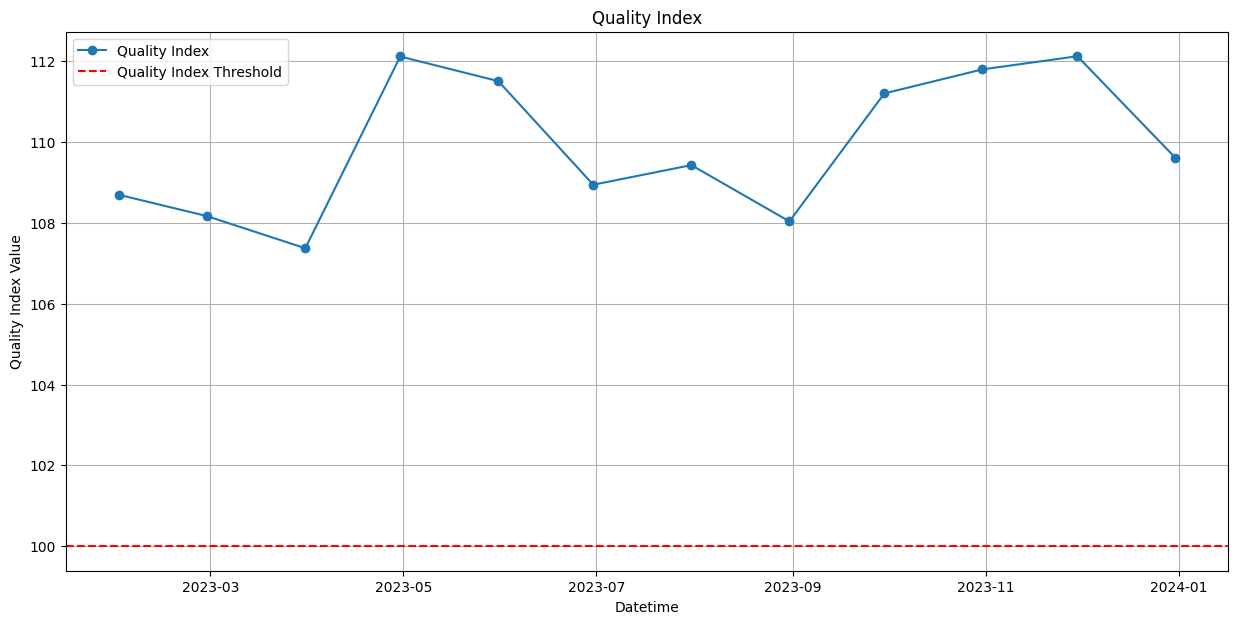

In [11]:
fig = plt.figure(figsize=(15,7))

plt.plot(output['Quality Index'], marker='o')

plt.axhline(y=100, color='r', linestyle='--')

plt.title('Quality Index')
plt.ylabel('Quality Index Value')
plt.xlabel('Datetime')

plt.legend(['Quality Index', f'Quality Index Threshold'])

plt.grid()
plt.show()


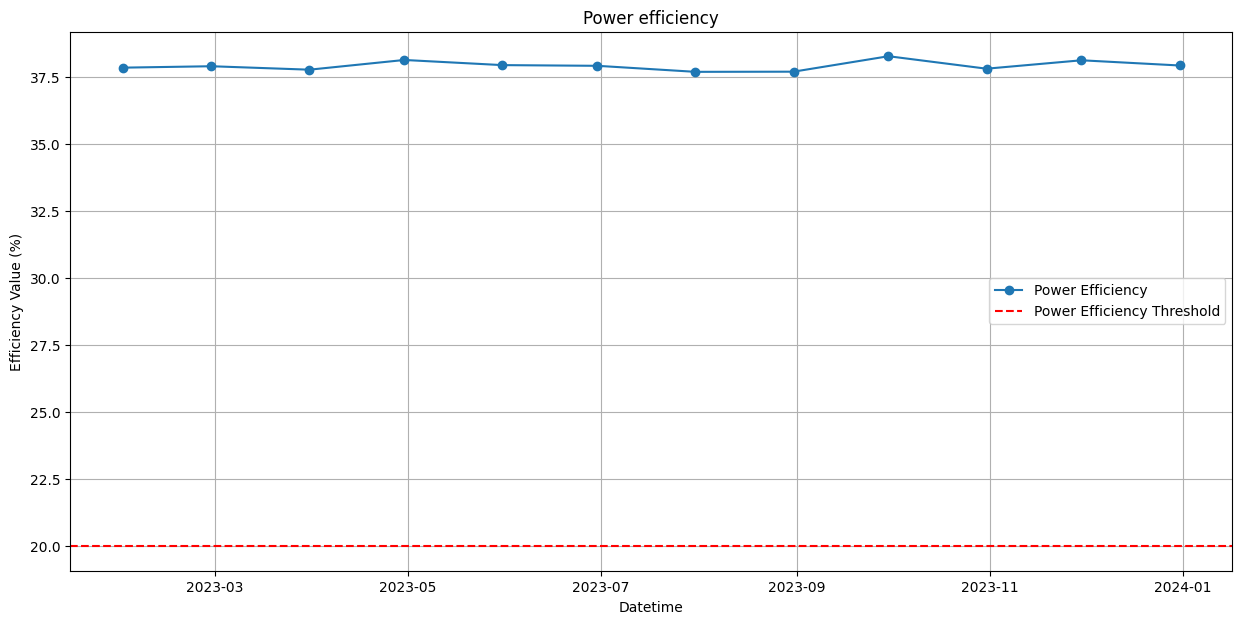

In [12]:
fig = plt.figure(figsize=(15,7))

plt.plot(output['Power Eff (%)'], marker='o')

plt.axhline(y=20, color='r', linestyle='--')

plt.title('Power efficiency')
plt.ylabel('Efficiency Value (%)')
plt.xlabel('Datetime')

plt.legend(['Power Efficiency', f'Power Efficiency Threshold'])

plt.grid()
plt.show()

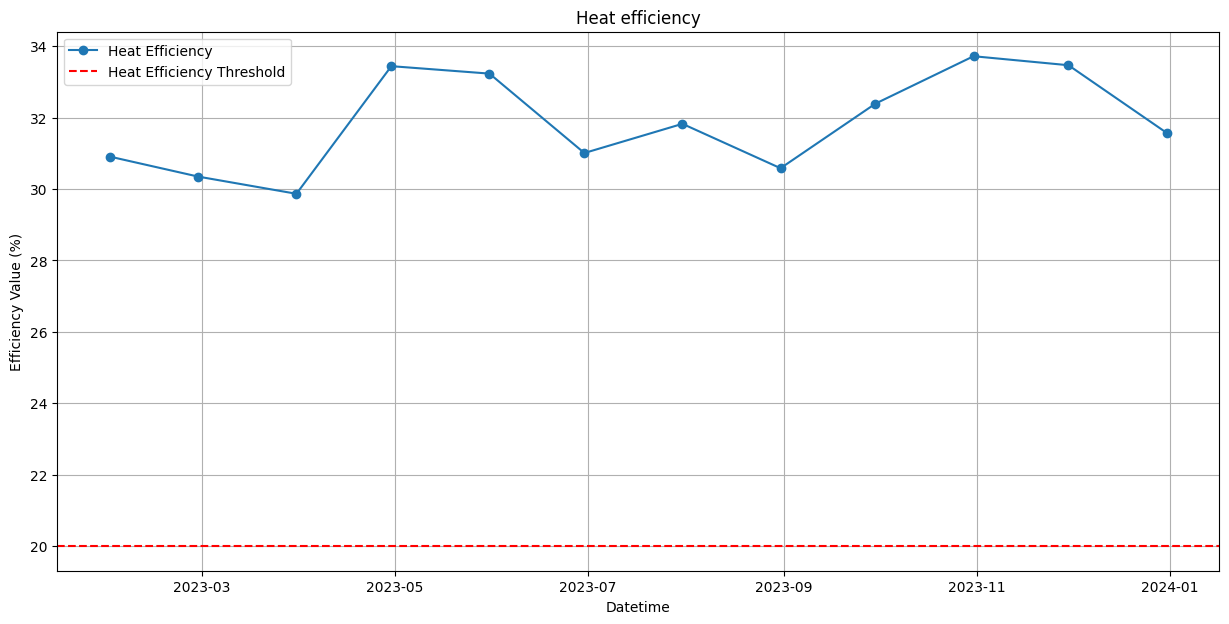

In [13]:
fig = plt.figure(figsize=(15,7))

plt.plot(output['Heat Eff (%)'], marker='o')

plt.axhline(y=20, color='r', linestyle='--')

plt.title('Heat efficiency')
plt.ylabel('Efficiency Value (%)')
plt.xlabel('Datetime')

plt.legend(['Heat Efficiency', f'Heat Efficiency Threshold'])

plt.grid()
plt.show()